In [785]:
import statsapi
import pprint
import datetime as dt
import numpy as np
import pandas as pd
from datetime import datetime
import time
import os
import statsmodels.formula.api as smf
import scipy.stats as stats

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [688]:
date = dt.datetime.now()
today = f'{date.month:02d}/{date.day}/{date.year}'

In [689]:
# 팀 코드

team_id = {'Baltimore Orioles':110, 'Boston Red Sox':111, 'Newyork Yankees':147, 'Tampa Bay Rays':139,'Toronto Blue Jays':141,
          'Chicago White Sox':145, 'Cleveland Guardians':114, 'Detroit Tigers':116, 'Kansas City Royals':118, 'Minnesota Twins':142,
          'Houston Astros':117,'Los Angeles Angels':108, 'Oakland Athletics':133,'Seattle Mariners':136,'Texas Rangers':140,
          'Atlanta Braves':144,'Miami Marlins':146,'New York Mets':121,'Philadelphia Phillies':143,'Washington Nationals':120,
          'Chicago Cubs':112,'Cincinnati Reds':113,'Milwaukee Brewers':158,'Pittsburgh Pirates':134,'St. Louis Cardinals':138,
          'Arizona Diamondbacks':109,'Los Angeles Dodgers':119,'Colorado Rockies':115,'San Diego Padres':135,'San Francisco Giants':137}

In [690]:
# 최종 순위에 접근하기 위한 각 해의 마지막 경기 날짜
last_day = {2013 : '2013-09-30', 2014:'2014-09-28',2015:'2015-10-04',2016:'2016-10-02',2017:'2017-10-01',2018:'2018-10-01',2019:'2019-09-29',2020:'2020-09-27',2021:'2021-10-03',2022:'2022-10-05'}

# 데이터 전처리

## ranking

In [767]:
def ranking (ranking_json, year):
    team_ranking = pd.DataFrame()

    for i in range(5):
        temp = pd.json_normalize(pd.json_normalize(ranking_json['teams'])[i])

        # 시즌, 팀명, 팀id, 지구순위, 리그순위, 승리, 패배 데이터
        temp_ranking = pd.DataFrame({'year': year, 'name': temp['name'], 'team_id':temp['team_id'],\
                                      'div_rank':temp['div_rank'],'league_rank':temp['league_rank'] ,'win':temp['w'], 'loss':temp['l']})
        team_ranking = pd.concat([team_ranking, temp_ranking], ignore_index = True)

    # div_rank와 league_rank의 타입을 object에서 int로 변환
    team_ranking = team_ranking.astype({'div_rank':'int','league_rank':'int'})

    return team_ranking

In [768]:
al_ranking = pd.DataFrame()

# 2013년부터 2022년까지 AL의 지구별 순위
for year in range(2013, 2023):
    al_ranking_json = pd.read_json(f'./Data/ranking/AL_{year}.json').transpose()
    al_ranking = pd.concat([al_ranking, ranking(al_ranking_json, year)], ignore_index = True)

al_ranking.head(3)

,year,name,team_id,div_rank,league_rank,win,loss
0,2013,Boston Red Sox,111,1,1,97,65
1,2013,Detroit Tigers,116,1,3,93,69
2,2013,Oakland Athletics,133,1,2,96,66


In [694]:
nl_ranking = pd.DataFrame()

# 2013년부터 2022년까지 NL의 지구별 순위
for year in range(2013, 2023):
    nl_ranking_json = pd.read_json(f'./Data/ranking/NL_{year}.json').transpose()
    nl_ranking = pd.concat([nl_ranking, ranking(nl_ranking_json, year)], ignore_index = True)


## player

In [695]:
player = pd.DataFrame()

for year in range(2013, 2023):
    player_json = pd.read_json(f'./Data/player/player_{year}.json').transpose()
    # 선수 id, season, 생일, 키, 몸무게, 데뷔일, 국적 Data
    df = pd.DataFrame({'id':player_json['id'],'season':year, 'birthday':player_json['birthDate'], \
                       'height':player_json['height'], 'weight':player_json['weight'], \
                        'DebutDate':player_json['mlbDebutDate'], 'country':player_json['birthCountry']})
    # 포지션 코드와 약칭
    df['position_code'] = pd.json_normalize(player_json['primaryPosition']).iloc[:,:1]
    df['position_abbreviation'] = pd.json_normalize(player_json['primaryPosition']).iloc[:,-1:]

    # 소속팀 id와 이름
    df['team_id'] = pd.json_normalize(player_json['currentTeam']).iloc[:, :1]
    df['team_name'] = pd.json_normalize(player_json['currentTeam']).iloc[:, 1:2]

    player = pd.concat([player, df], ignore_index=True)


In [696]:
player.head(3)

,id,season,birthday,height,weight,DebutDate,country,position_code,position_abbreviation,team_id,team_name
0,430911,2013,1981-12-27,"6' 3""",215,2004-04-06,USA,1,P,121,New York Mets
1,472551,2013,1985-12-17,"6' 2""",235,2010-07-28,Dominican Republic,1,P,120,Washington Nationals
2,473234,2013,1984-11-13,"5' 10""",200,2007-05-22,Dominican Republic,4,2B,137,San Francisco Giants


## player_record

In [697]:
def batter(year, player_record):
    batter_record_json = pd.read_json(f'./Data/player_record/{year}/{player_record}')
    # 빈파일 제거
    try:
        # player_id, season, avg(타율), ops(타율 + 장타율)
        # plateAppearances(타석), runs(득점), rbi(타점)
        # hits, doubles, triples homeRuns
        # baseOnBalls, hitByPitch(데드볼), intentionalWalks(고의사구)
        # groundOuts + airOuts, (sacBunts + sacFlies)(희생타)
        # stolenBases(도루),caughtStealing(도루실패), strikeOuts(삼진), groundIntoDoublePlay(병살),  
        temp = pd.json_normalize(batter_record_json['stats'])
        temp_df = pd.DataFrame({'player_id':player_record[2:8], 'season':temp['season'],'avg':temp['stats.avg'], 'ops':temp['stats.ops'],\
                                'plateAppearances':temp['stats.plateAppearances'], 'runs':temp['stats.runs'], 'rbi':temp['stats.rbi'],\
                                'hits':temp['stats.hits'],'doubles':temp['stats.doubles'], 'triples':temp['stats.triples'], 'homeRuns':temp['stats.homeRuns'],\
                                'BB':temp['stats.baseOnBalls'], 'hitByPitch': temp['stats.hitByPitch'], 'intentionalWalks':temp['stats.intentionalWalks'],\
                                'groundOuts':temp['stats.groundOuts'], 'airOuts':temp['stats.airOuts'], 'sac':temp['stats.sacBunts'] + temp['stats.sacFlies'],\
                                'caughtStealing':temp['stats.caughtStealing'],'stolenBases':temp['stats.stolenBases'], 'K':temp['stats.strikeOuts'],'DoublePlay':temp['stats.groundIntoDoublePlay']})
        temp_df = temp_df.astype({'player_id':'int', 'season':'int','avg':'float', 'ops':'float'})

        return 1, temp_df 
    
    except:
        return 0, pd.NA


In [698]:
def pitcher(year, player_record):
    pitcher_record_json = pd.read_json(f'./Data/player_record/{year}/{player_record}')
    # 빈파일 제거를 위한 try - except
    try:
        temp = pd.json_normalize(pitcher_record_json['stats'])
        # player_id, season(시즌) ear(평균자책점), inningsPitched(이닝)
        # gamesPlayed(경기수), gamesStarted(선발), wins, losses, saves, holds
        # completeGames(완봉), shutouts(완투), blonSaves
        # outs, strikeOuts, K/9, baseOnBalls, groundIntoDoublePlay(병살)
        # hits, doubles, triples, homeRuns, runs(실점), earnedRuns(자책점), wildPitches(폭투), balks(보크)
        temp_df = pd.DataFrame({'player_id':player_record[2:8],'season':temp['season'],'era':temp['stats.era'], 'innings':temp['stats.inningsPitched'],\
                                'played':temp['stats.gamesPlayed'], 'started':temp['stats.gamesStarted'], 'wins':temp['stats.wins'],'losses':temp['stats.losses'], 'saves':temp['stats.saves'], 'holds':temp['stats.holds'],\
                                'completeGames':temp['stats.completeGames'], 'shutouts':temp['stats.shutouts'],'blownSaves': temp['stats.blownSaves'], \
                                'outs':temp['stats.outs'], 'K':temp['stats.strikeOuts'],'K/9':temp['stats.strikeoutsPer9Inn'], 'BB':temp['stats.baseOnBalls'], 'DoublePlay':temp['stats.groundIntoDoublePlay'],\
                                'hits':temp['stats.hits'], 'doubles':temp['stats.doubles'], 'triples':temp['stats.triples'], 'homeRuns':temp['stats.homeRuns'],\
                                'runs':temp['stats.runs'], 'earnedRuns':temp['stats.earnedRuns'], 'wildPitches':temp['stats.wildPitches'], 'balks':temp['stats.balks']})
        temp_df = temp_df.astype({'player_id':'int', 'season':'int','era':'float', 'innings':'float', 'K/9':'float'})
        return 1, temp_df
    except:
        return 0, pd.NA

In [699]:
pitcher_record = pd.DataFrame()
batter_record = pd.DataFrame()

for year in range(2022, 2012, -1):
    if year == 2020:
        continue

    for file in os.walk(f'./Data/player_record/{year}'):
        for player_record in file[2]:
            if 'p' in player_record[:1]:
                bool, df = pitcher(year, player_record)
                if bool == 1:
                    pitcher_record = pd.concat([pitcher_record, df], ignore_index = True)
                    
            else:
                bool, df = batter(year, player_record)
                if bool == 1:
                    batter_record = pd.concat([batter_record, df], ignore_index = True)   

In [700]:
# 2013년도 이전의 기록 삭제
pitcher_record = pitcher_record[pitcher_record['season'] > 2012]
batter_record = batter_record[batter_record['season'] > 2012 ]

# 시각화

### 1. 이적과 성적 변화(투 : era, 타 : ops)의 관계

In [701]:
player_info = player[['id','season','team_id','team_name','birthday','height','weight','DebutDate','country','position_abbreviation']]

In [ ]:
# 이적 여부를 판단하는 함수
def is_transferred(row, temp):
    previous_season = row['season'] - 1
    previous_row = df[(df['id'] == row['id']) & (df['season'] == previous_season)]

    if len(previous_row) == 0:
        return False  # 이전 시즌 데이터가 없으므로 이적하지 않음

    previous_team_id = previous_row['team_id'].values[0]
    return previous_team_id != row['team_id']

#### 타자

In [836]:
# 100타석 이상의 선수 데이터만 확인
batter_info = pd.merge(batter_record, player_info, how='inner', left_on=['player_id', 'season'], right_on=['id', 'season'])
batter_info = batter_info[batter_info['plateAppearances'] >= 100]

In [837]:
len(batter_info)

4592

In [838]:
# 타자 데이터에 이적여부 및 성적 변화 컬럼 추가
df = batter_info.copy()
temp = df.copy()

# 이적 여부 컬럼 추가
df['transferred'] = df.apply(is_transferred, temp=temp, axis=1)

# 이전 시즌 점수 컬럼 추가
temp['previous_ops'] = temp.groupby('player_id')['ops'].shift()

# 점수 변화 컬럼 추가
df['ops_change'] = df['ops'] - temp['previous_ops']

# 첫 번째 시즌 제외한 데이터 추출
batter_transfer = df.groupby('player_id').apply(lambda x: x.iloc[1:]).reset_index(drop=True)

In [839]:
len(batter_transfer)

3480

t-statistic: -1.0036
p-value: 0.3157


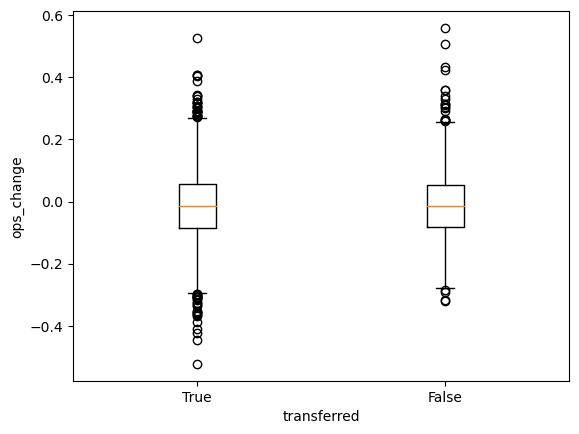

In [784]:
# t 검정
group1 = np.array(batter_transfer['ops_change'])[np.array(batter_transfer['transferred']) == False]
group2 = np.array(batter_transfer['ops_change'])[np.array(batter_transfer['transferred']) == True]
t_statistic, p_value = stats.ttest_ind(group1, group2)

print(f"t-statistic: {t_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# 시각화
plt.boxplot([group1, group2], labels=[True, False])
plt.xlabel('transferred')
plt.ylabel('ops_change')
plt.show()

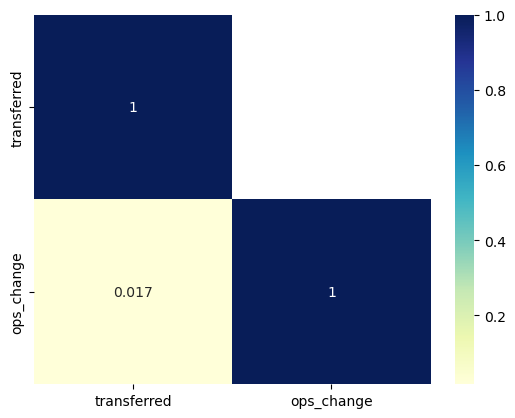

In [705]:
# 상관관계분석
corr = batter_transfer[['transferred','ops_change']].corr()
mask = np.array(corr)

mask[np.tril_indices_from(mask)] = False

sns.heatmap(data=corr,mask=mask, annot=True, cmap='YlGnBu')

plt.show()

In [787]:
formula = 'ops_change ~ transferred'
result = smf.ols(formula, batter_transfer).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             ops_change   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.007
Date:                Thu, 01 Jun 2023   Prob (F-statistic):              0.316
Time:                        21:49:53   Log-Likelihood:                 2542.9
No. Observations:                3480   AIC:                            -5082.
Df Residuals:                    3478   BIC:                            -5070.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0137    

#### 투수

In [707]:
pitcher_info = pd.merge(pitcher_record, player_info, how='inner', left_on=['player_id', 'season'], right_on=['id', 'season']) # .drop(labels=['era'], axis=1)
# pitcher_info = pitcher_info[((pitcher_df['innings']/pitcher_df['played']) >= 4.5) & (pitcher_df['innings'] >= 100) | ((pitcher_df['innings']/pitcher_df['played']) < 4.5) & (pitcher_df['innings'] >= 40)]

s_pitcher_info = pitcher_info[((pitcher_info['innings']/pitcher_info['played']) >= 4.5) & (pitcher_info['innings'] >= 80)]
m_pitcher_info = pitcher_info[((pitcher_info['innings']/pitcher_info['played']) < 4.5) & (pitcher_info['innings'] >= 20)]

선발투수

In [788]:
len(s_pitcher_info)

1419

In [708]:
# 타자 데이터에 이적여부 및 성적 변화 컬럼 추가
df = s_pitcher_info.copy()
temp = df.copy()

# 이적 여부 컬럼 추가
df['transferred'] = df.apply(is_transferred, temp=temp, axis=1)

# 이전 시즌 점수 컬럼 추가
temp['previous_era'] = temp.groupby('player_id')['era'].shift()

# 점수 변화 컬럼 추가
df['era_change'] = df['era'] - temp['previous_era']

# 첫 번째 시즌 제외한 데이터 추출
s_pitcher_transfer = df.groupby('player_id').apply(lambda x: x.iloc[1:]).reset_index(drop=True)

t-statistic: 1.0127
p-value: 0.3114


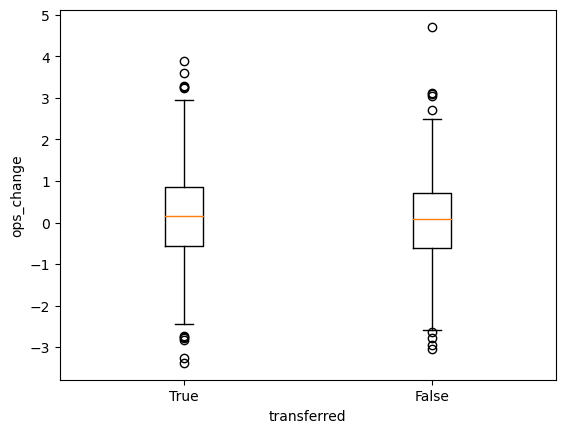

In [786]:
# t 검정
group1 = np.array(s_pitcher_transfer['era_change'])[np.array(s_pitcher_transfer['transferred']) == False]
group2 = np.array(s_pitcher_transfer['era_change'])[np.array(s_pitcher_transfer['transferred']) == True]
t_statistic, p_value = stats.ttest_ind(group1, group2)

print(f"t-statistic: {t_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# 시각화
plt.boxplot([group1, group2], labels=[True, False])
plt.xlabel('transferred')
plt.ylabel('ops_change')
plt.show()

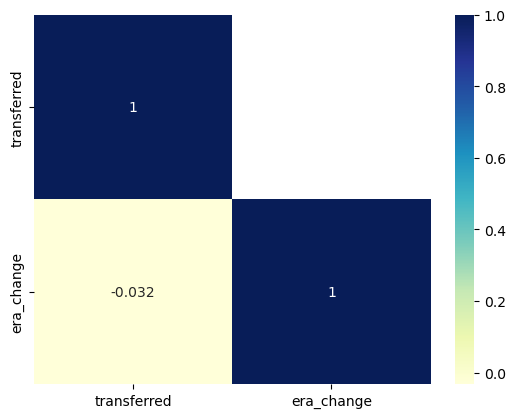

In [709]:
corr = s_pitcher_transfer[['transferred','era_change']].corr()
mask = np.array(corr)

mask[np.tril_indices_from(mask)] = False

sns.heatmap(data=corr,mask=mask, annot=True, cmap='YlGnBu')

plt.show()

In [710]:
formula = 'era_change ~ transferred'
result = smf.ols(formula, s_pitcher_transfer[['era_change','transferred']]).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             era_change   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.026
Date:                Thu, 01 Jun 2023   Prob (F-statistic):              0.311
Time:                        16:00:33   Log-Likelihood:                -1497.6
No. Observations:                 989   AIC:                             2999.
Df Residuals:                     987   BIC:                             3009.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1466    

중간계투 및 마무리투수

In [791]:
len(m_pitcher_info)

4909

In [711]:
# 타자 데이터에 이적여부 및 성적 변화 컬럼 추가
df = m_pitcher_info.copy()
temp = df.copy()

# 이적 여부 컬럼 추가
df['transferred'] = df.apply(is_transferred, temp=temp, axis=1)

# 이전 시즌 점수 컬럼 추가
temp['previous_era'] = temp.groupby('player_id')['era'].shift()

# 점수 변화 컬럼 추가
df['era_change'] = df['era'] - temp['previous_era']

# 첫 번째 시즌 제외한 데이터 추출
filtered_df = df.groupby('player_id').apply(lambda x: x.iloc[1:]).reset_index(drop=True)

m_pitcher_transfer = filtered_df.copy()

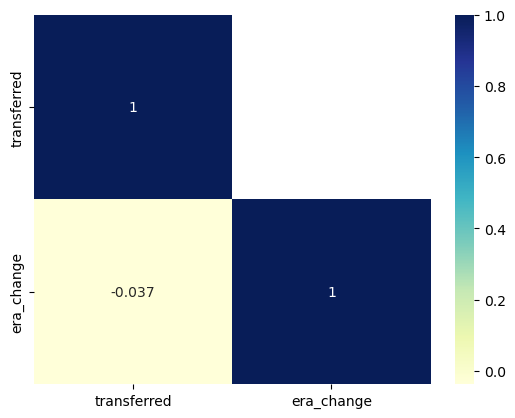

In [712]:
corr = m_pitcher_transfer[['transferred','era_change']].corr()
mask = np.array(corr)

mask[np.tril_indices_from(mask)] = False

sns.heatmap(data=corr,mask=mask, annot=True, cmap='YlGnBu')

plt.show()

In [713]:
formula = 'era_change ~ transferred'
result = smf.ols(formula, m_pitcher_transfer[['era_change','transferred']]).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             era_change   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.712
Date:                Thu, 01 Jun 2023   Prob (F-statistic):             0.0300
Time:                        16:00:38   Log-Likelihood:                -7744.1
No. Observations:                3390   AIC:                         1.549e+04
Df Residuals:                    3388   BIC:                         1.550e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.2085    

### 2. 선수 영입을 위한 부족한 부분 파악 및 분석 (타자 / 팀 : Oakland)




In [738]:
b_record = pd.merge(batter_record, player, how='inner', left_on=['player_id', 'season'], right_on=['id', 'season']).drop(labels=['id','height','weight','DebutDate','country','team_id'], axis=1)

# 2022년도 162타석 이상 들어선 타자들의 데이터
b_record = b_record[(b_record['season'] == 2022) & (b_record['plateAppearances'] >= 162)]

In [739]:
len(b_record)

452

#### 2.1 mlb 모든 팀의 ops, avg boxplot

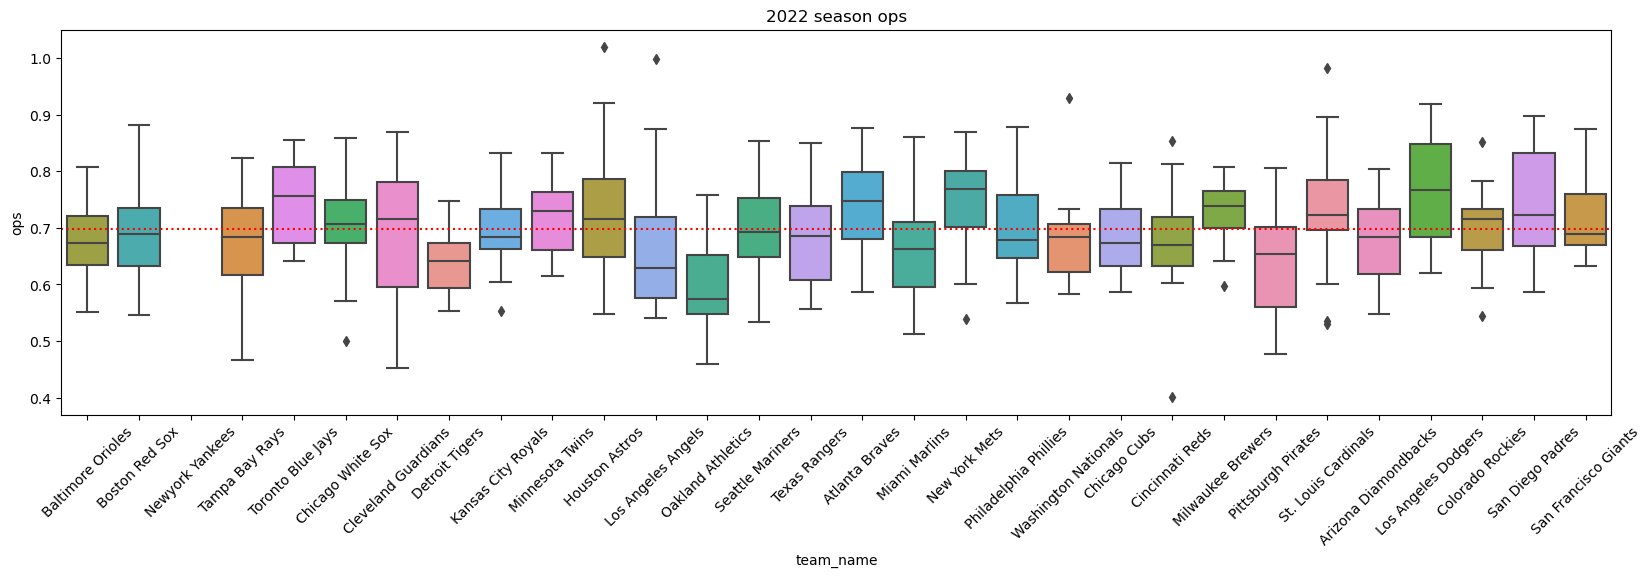

In [831]:
# 팀별 타자들의 ops값
plt.figure(figsize=(20,5))

ax = sns.boxplot(x='team_name', y='ops', hue='team_name', data=b_record, dodge=False, order = team_id.keys())
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

mean = b_record['ops'].mean()
plt.axhline(mean, color='r', linestyle=':', label='ops mean')

ax.get_legend().remove()
ax.set_title('2022 season ops')

plt.show()

#### 2.2 가장 성적이 안좋은 선수의 포지션 파악

In [730]:
# 타자 Oakland 기준
team_batter = batter_info[(batter_info['season'] == 2022) & (batter_info['team_id'] == 133)].sort_values('ops')

In [832]:
len(team_batter)

17

C:\Users\medici\AppData\Local\Temp\ipykernel_9684\2982735009.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 10);


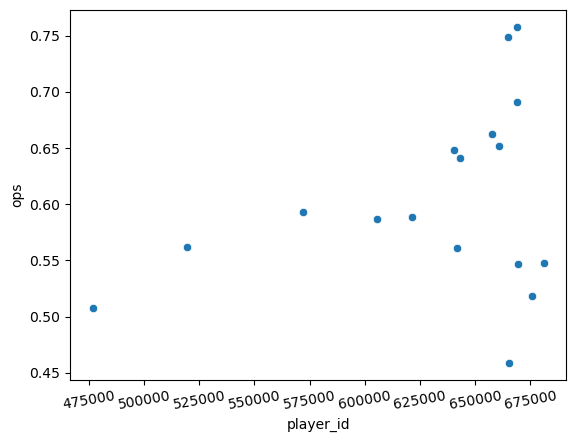

In [834]:
ax = sns.scatterplot(x='player_id', y='ops', data=team_batter)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 10);

In [732]:
position = team_batter.iloc[1, -1:].item()
position

'SS'

#### 2.3 ops와 다른 변수들 사이의 관계

In [733]:
def bmi(x):
    return round(x[1] / x[0]**2)

def ft_m(x):
    height = round(float(x.replace('\' ','.').replace('"','')) * 0.3, 2) # 키를 ft에서 m로 변환
    
    return height

In [734]:
temp_para1 = pd.merge(batter_info, al_ranking, how = 'inner', left_on = ['team_id','season'], right_on = ['team_id', 'year'])
temp_para2 = pd.merge(batter_info, nl_ranking, how = 'inner', left_on = ['team_id','season'], right_on = ['team_id', 'year'])
batter_parameter = pd.concat([temp_para1, temp_para2], ignore_index = True)

In [735]:
# 가장 낮은 ops를 기록한 타자와 동일한 포지션의 타자 데이터 추출
batter_parameter = batter_parameter[batter_parameter['position_abbreviation'] == position]

# BMI 지수
batter_parameter['weight'] = (batter_parameter['weight'] * 0.45).astype(float)
batter_parameter['height'] = batter_parameter['height'].apply(ft_m)
batter_parameter['bmi'] = batter_parameter[['height', 'weight']].apply(bmi, axis = 1)


# 승률
batter_parameter['winRate'] = round(batter_parameter['win'] / (batter_parameter['win'] + batter_parameter['loss']), 3)

# 나이
birthday = batter_parameter['birthday'].apply(lambda _:datetime.strptime(_, '%Y-%m-%d'))
temp = batter_parameter['season'].map(last_day).apply(lambda _:datetime.strptime(_, '%Y-%m-%d'))
batter_parameter['age'] = round((temp - birthday).dt.days / 365.25,3)

batter = batter_parameter[['winRate','age','weight','height','bmi', 'ops']]


winRate => Statistic:0.991707444190979, P-value : 0.0053686280734837055
age => Statistic:0.9851130843162537, P-value : 3.7469151720870286e-05
weight => Statistic:0.9545071721076965, P-value : 1.467469028237911e-11
height => Statistic:0.7382814884185791, P-value : 8.659346956654446e-28
bmi => Statistic:0.8246071934700012, P-value : 2.099021922539966e-23
ops => Statistic:0.9951838850975037, P-value : 0.10698816925287247


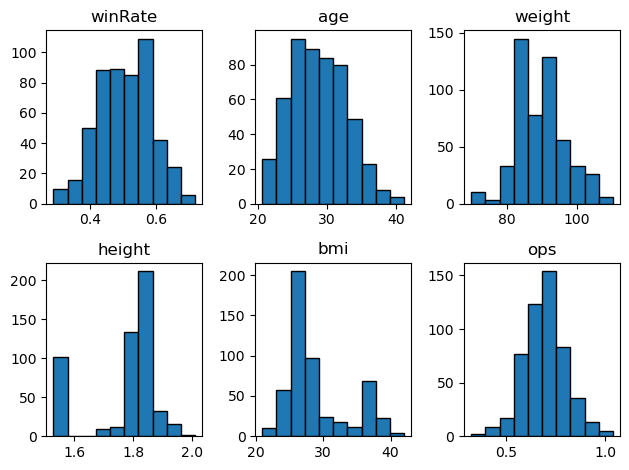

In [804]:
# 정규성 검정
for seq, normality in enumerate(batter):
    
    # 샤피로-위츠 검정 수행
    statistic, p_value = stats.shapiro(batter[normality])

    # 결과 출력
    print(f'{normality} => Statistic:{statistic}, P-value : {p_value}')

    # 시각화
    plt.subplot(2, 3, seq+1)
    plt.title(normality)
    plt.hist(batter[normality], bins=10, edgecolor='black')

plt.tight_layout()
plt.show()

winRate에 대한 Levene 결과 - Statistics : 67.57232773000429 p-value : 6.025808010464167e-16

age에 대한 Levene 결과 - Statistics : 1024.2133198343913 p-value : 7.858372553103587e-157

weight에 대한 Levene 결과 - Statistics : 631.8189014104855 p-value : 3.0723997219923085e-109

height에 대한 Levene 결과 - Statistics : 0.24877409162519948 p-value : 0.618045484766008

bmi에 대한 Levene 결과 - Statistics : 375.8761016987486 p-value : 1.1018102939534463e-71

ops에 대한 Levene 결과 - Statistics : 770.858446886104 p-value : 2.8068772008493326e-127



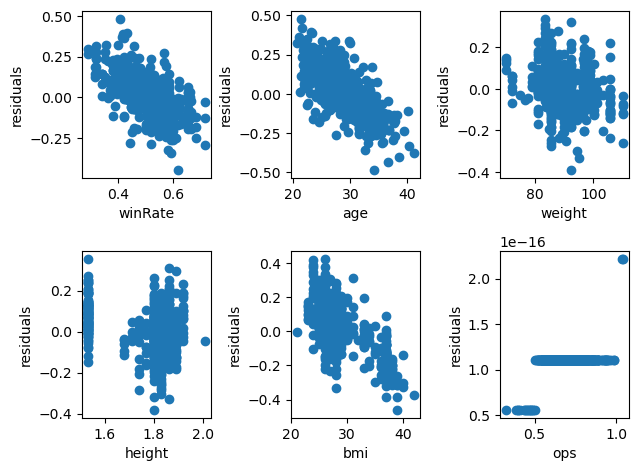

In [835]:
# 등분산성 검사

for seq, normality in enumerate(batter):

    # 최소자승법 회귀분석
    model = sm.OLS(batter['ops'], batter[normality])
    result = model.fit()
    residuals = result.resid

    # Bartlett의 검정 수행
    bartlett_stat, bartlett_pval = stats.bartlett(batter[normality], residuals)
    # print(f'{normality}에 대한 Bartlett 결과 -  Statistics :{bartlett_stat} p-value : {bartlett_pval}')

    # Levene의 검정 수행
    levene_stat, levene_pval = stats.levene(batter[normality], residuals)
    print(f'{normality}에 대한 Levene 결과 - Statistics : {levene_stat} p-value : {levene_pval}\n')

    # 잔차 대 독립변수 산점도 그리기
    plt.subplot(2,3,seq + 1)
    plt.scatter(batter[normality], residuals)
    plt.xlabel(normality)
    plt.ylabel('residuals')


# plt.supertitle('Residuals vs Independent Variable')
plt.tight_layout()    
plt.show()


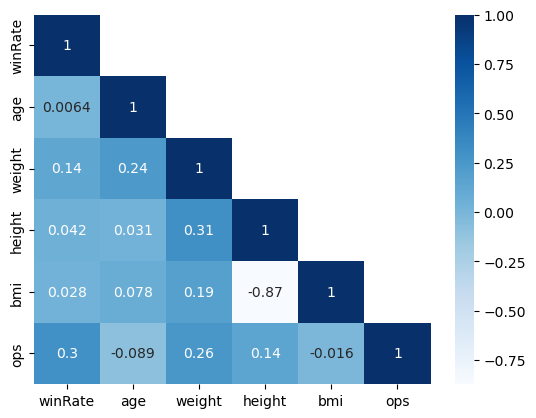

In [811]:
# 상관관계 분석
corr = batter.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False

sns.heatmap(data=corr,mask=mask, annot=True, cmap='Blues')

plt.show()

In [828]:
formula = 'ops ~ winRate + weight + age'
result = smf.ols(formula, batter).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    ops   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     32.43
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           3.24e-19
Time:                        22:46:06   Log-Likelihood:                 469.59
No. Observations:                 519   AIC:                            -931.2
Df Residuals:                     515   BIC:                            -914.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2858      0.062      4.634      0.0

### 3. 선수 영입을 위한 부족한 부분 파악 및 분석 (투수 / 팀 : Los Angeles Dodgers)


In [746]:
p_record = pd.merge(pitcher_record, player, how='inner', left_on=['player_id', 'season'], right_on=['id', 'season']).drop(labels=['id','height','weight','DebutDate','country','team_id'], axis=1)
mp_record = p_record[(p_record['season'] == 2022) & (p_record['innings']/p_record['played'] < 4.5) & (p_record['innings'] > 30)]
sp_record = p_record[(p_record['season'] == 2022) & (p_record['innings']/p_record['played']>= 4.5) & (p_record['innings'] > 100)]

In [747]:
len(sp_record)

123

In [748]:
len(mp_record)

346

#### 3.1 mlb 모든 팀의 era

Text(0.5, 1.0, '2022 season era')

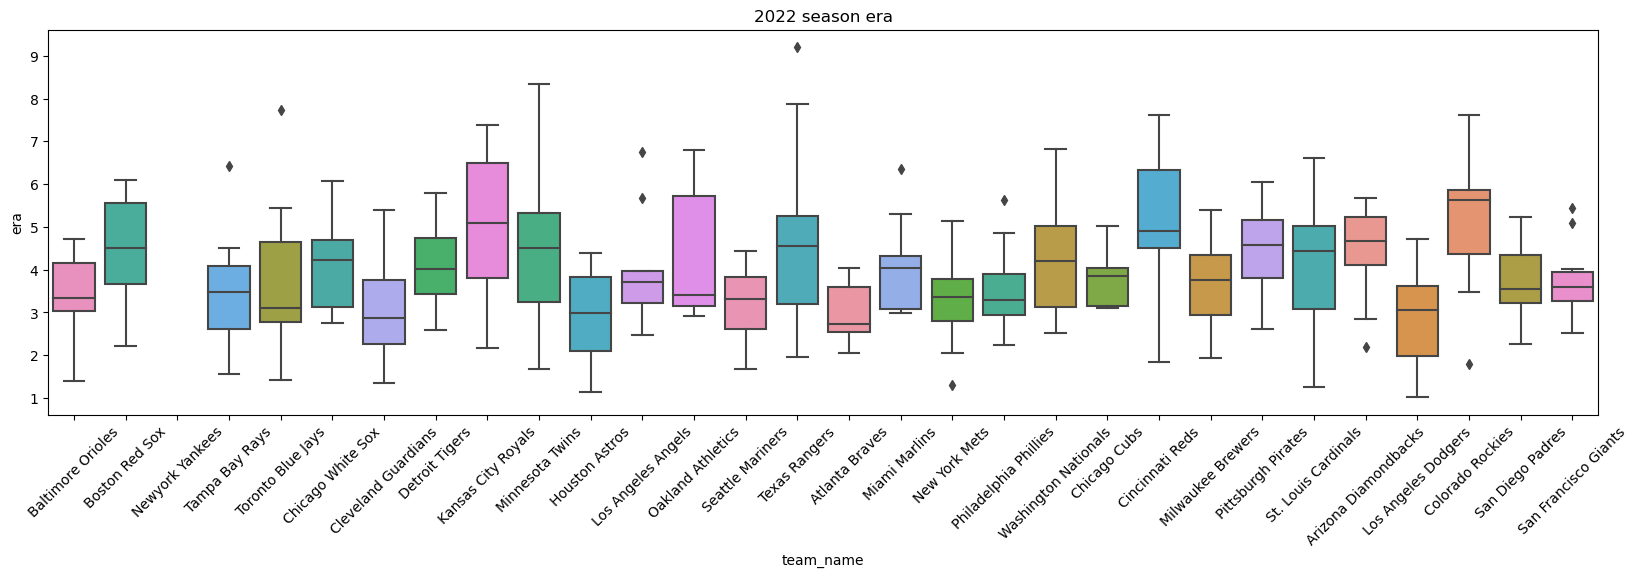

In [754]:
plt.figure(figsize=(20,5))

ax = sns.boxplot(x='team_name', y='era', hue='team_name', data=mp_record, dodge=False, order = team_id.keys())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.get_legend().remove()
ax.set_title('2022 season era')